# Machine Learning
## Assessment 2 Experiment 1
### Ronik Jayakumar
### 24680264

## Context
The project is performed for a car reseller company that wants to analyse car repurchase trends based on past data relating to car maintenance for a population of customers. In this experiment, the Support Vector Machine model is explored into to check for feasibility using various evaluation metrics


### 0. Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import f_classif, SelectKBest

### 1.   Load Dataset

In [2]:
df = pd.read_csv('/Users/ronikj/Downloads/repurchase_dataset.csv')
df.head()

,ID,Target,age_band,gender,car_model,car_segment,age_of_vehicle_years,sched_serv_warr,non_sched_serv_warr,sched_serv_paid,non_sched_serv_paid,total_paid_services,total_services,mth_since_last_serv,annualised_mileage,num_dealers_visited,num_serv_dealer_purchased
0,1,0,3. 35 to 44,Male,model_1,LCV,9,2,10,3,7,5,6,9,8,10,4
1,2,0,NaN,NaN,model_2,Small/Medium,6,10,3,10,4,9,10,6,10,7,10
2,3,0,NaN,Male,model_3,Large/SUV,9,10,9,10,9,10,10,7,10,6,10
3,5,0,NaN,NaN,model_3,Large/SUV,5,8,5,8,4,5,6,4,10,9,7
4,6,0,NaN,Female,model_2,Small/Medium,8,9,4,10,7,9,8,5,4,4,9


### 2. Explore Dataset

In [3]:
df.shape

(131337, 17)

In [4]:
df.isnull().sum()

ID                                0
Target                            0
age_band                     112375
gender                        69308
car_model                         0
car_segment                       0
age_of_vehicle_years              0
sched_serv_warr                   0
non_sched_serv_warr               0
sched_serv_paid                   0
non_sched_serv_paid               0
total_paid_services               0
total_services                    0
mth_since_last_serv               0
annualised_mileage                0
num_dealers_visited               0
num_serv_dealer_purchased         0
dtype: int64

### 2.1 Age Band Column

The age_band column has been explored into and shows no significant impact on the target variable. Since more than 90% of the column consists of null values, this column has been decided to be dropped.

In [5]:
df = df.drop(['age_band'], axis=1)

### 2.2 Car Model Column

In [6]:
model_counts = df.groupby('car_model')['Target'].value_counts().unstack(fill_value=0)

print("Frequency of target value 1 for each car model:")
print(model_counts[1])

Frequency of target value 1 for each car model:
car_model
model_1     418
model_10     45
model_11      9
model_12      6
model_13     39
model_14      0
model_15     10
model_16      4
model_17      2
model_18      5
model_19      0
model_2     817
model_3     667
model_4     318
model_5     582
model_6      58
model_7     296
model_8     218
model_9      27
Name: 1, dtype: int64


In [7]:
car_model_frequency = df['car_model'].value_counts()
car_model_frequency

model_2     34491
model_5     24674
model_3     17074
model_1     15331
model_4     15155
model_7      8167
model_8      6443
model_10     3215
model_6      3071
model_9       994
model_13      714
model_12      614
model_11      612
model_15      334
model_17      153
model_16      114
model_18      101
model_14       78
model_19        2
Name: car_model, dtype: int64

It has been noticed that the car model column consists of a highly imbalanced dataset. Since the imbalance also contributes to a highly skewed correlation with the target column, this column will be dropped going ahead with the modelling process.

In [8]:
df = df.drop(['car_model'], axis=1)

### 2.3 Car Segment Column

In [9]:
df['car_segment'].value_counts()

Small/Medium    54553
Large/SUV       52120
LCV             24606
Other              58
Name: car_segment, dtype: int64

In [10]:
model_counts1 = df.groupby('car_segment')['Target'].value_counts().unstack(fill_value=0)

print("Frequency of target value 1 for each car segment:")
print(model_counts1[1])

Frequency of target value 1 for each car segment:
car_segment
LCV              745
Large/SUV       1551
Other              1
Small/Medium    1224
Name: 1, dtype: int64


The rows containing 'Other' values in car segment column will be dropped to increase model interpretability. Due to the absence of data and context on the 'Other' segment, for this experiment we will consider 3 car segments, namely - 'LCV', 'Large/SUV', 'Small/Medium'.

Following this, the car segment column has been encoded into integer values to facilitate modeling.

In [11]:
df = df[df['car_segment'] != 'Other']

In [12]:
encoder = LabelEncoder()

In [13]:
df['car_segment'] = encoder.fit_transform(df['car_segment'])

### 2.4 Gender Column
The gender column has been worked on to convert it into integer values. Since around 50% of the rows consist of null values, we will now use Multivariate Imputation by Chained Equations (MICE) imputation to predict null values.

In [14]:
encoder = LabelEncoder()
impute_col = 'gender'
impute_col_encoded = 'gender_no'
encoder.fit(df.loc[:, impute_col])

LabelEncoder()

In [15]:
dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

{'Female': 0, 'Male': 1, nan: 2}

Encode the Male, Female, and Nan values

In [16]:
df[impute_col_encoded] = encoder.transform(df[impute_col])
df[['gender', 'gender_no']].head()

,gender,gender_no
0,Male,1
1,NaN,2
2,Male,1
3,NaN,2
4,Female,0


Decode the Nan value back to its original form to ensure the values are predicted.

In [17]:
df[impute_col_encoded] = df[impute_col_encoded].map(lambda x: np.nan if x == 2 else x)

In [18]:
imputer = IterativeImputer(random_state=42)

In [19]:
df_train = df.loc[:, ['Target', impute_col_encoded, 'car_segment', 'age_of_vehicle_years',
                     'sched_serv_warr', 'non_sched_serv_warr', 'sched_serv_paid', 'non_sched_serv_paid',
                     'total_paid_services', 'total_services', 'mth_since_last_serv', 'annualised_mileage',
                     'num_dealers_visited', 'num_serv_dealer_purchased']]

imputer.fit(df_train)
df_imputed = imputer.transform(df_train)
df_imputed[:, 1].round()
df.loc[:, [impute_col_encoded]] = df_imputed[:, 1].round()
df.head()

,ID,Target,gender,car_segment,age_of_vehicle_years,sched_serv_warr,non_sched_serv_warr,sched_serv_paid,non_sched_serv_paid,total_paid_services,total_services,mth_since_last_serv,annualised_mileage,num_dealers_visited,num_serv_dealer_purchased,gender_no
0,1,0,Male,0,9,2,10,3,7,5,6,9,8,10,4,1.0
1,2,0,NaN,2,6,10,3,10,4,9,10,6,10,7,10,0.0
2,3,0,Male,1,9,10,9,10,9,10,10,7,10,6,10,1.0
3,5,0,NaN,1,5,8,5,8,4,5,6,4,10,9,7,1.0
4,6,0,Female,2,8,9,4,10,7,9,8,5,4,4,9,0.0


In [20]:
df[impute_col_encoded].value_counts()

1.0    78048
0.0    53231
Name: gender_no, dtype: int64

In [21]:
print("Shape after dropping:", df.shape)

Shape after dropping: (131279, 16)


### 3. Explore Target variable

In [22]:
df['Target'].value_counts()

0    127759
1      3520
Name: Target, dtype: int64

The target column is imbalanced with very few rows corresponsing to the positive target value. The imbalance is also an indication of how the market works.

### 4. Explore Variables of Interest

To explore into variables and their relation to the target value, the correlation analysis and the ANOVA-F test have been chosen. All the categorical columns have been converted into numerical columns. We will drop the gender column now that the gender_no column has been created with no null values.

In [23]:
df = df.drop(['gender', 'ID'], axis=1)
df.head()

,Target,car_segment,age_of_vehicle_years,sched_serv_warr,non_sched_serv_warr,sched_serv_paid,non_sched_serv_paid,total_paid_services,total_services,mth_since_last_serv,annualised_mileage,num_dealers_visited,num_serv_dealer_purchased,gender_no
0,0,0,9,2,10,3,7,5,6,9,8,10,4,1.0
1,0,2,6,10,3,10,4,9,10,6,10,7,10,0.0
2,0,1,9,10,9,10,9,10,10,7,10,6,10,1.0
3,0,1,5,8,5,8,4,5,6,4,10,9,7,1.0
4,0,2,8,9,4,10,7,9,8,5,4,4,9,0.0


### 4.1 Correlation Analysis

In [24]:
# Rearranging columns
df = df[['car_segment', 'age_of_vehicle_years', 'sched_serv_warr', 'non_sched_serv_warr',
         'sched_serv_paid', 'non_sched_serv_paid', 'total_paid_services', 'total_services',
         'mth_since_last_serv', 'annualised_mileage', 'num_dealers_visited', 'num_serv_dealer_purchased',
         'gender_no', 'Target']]

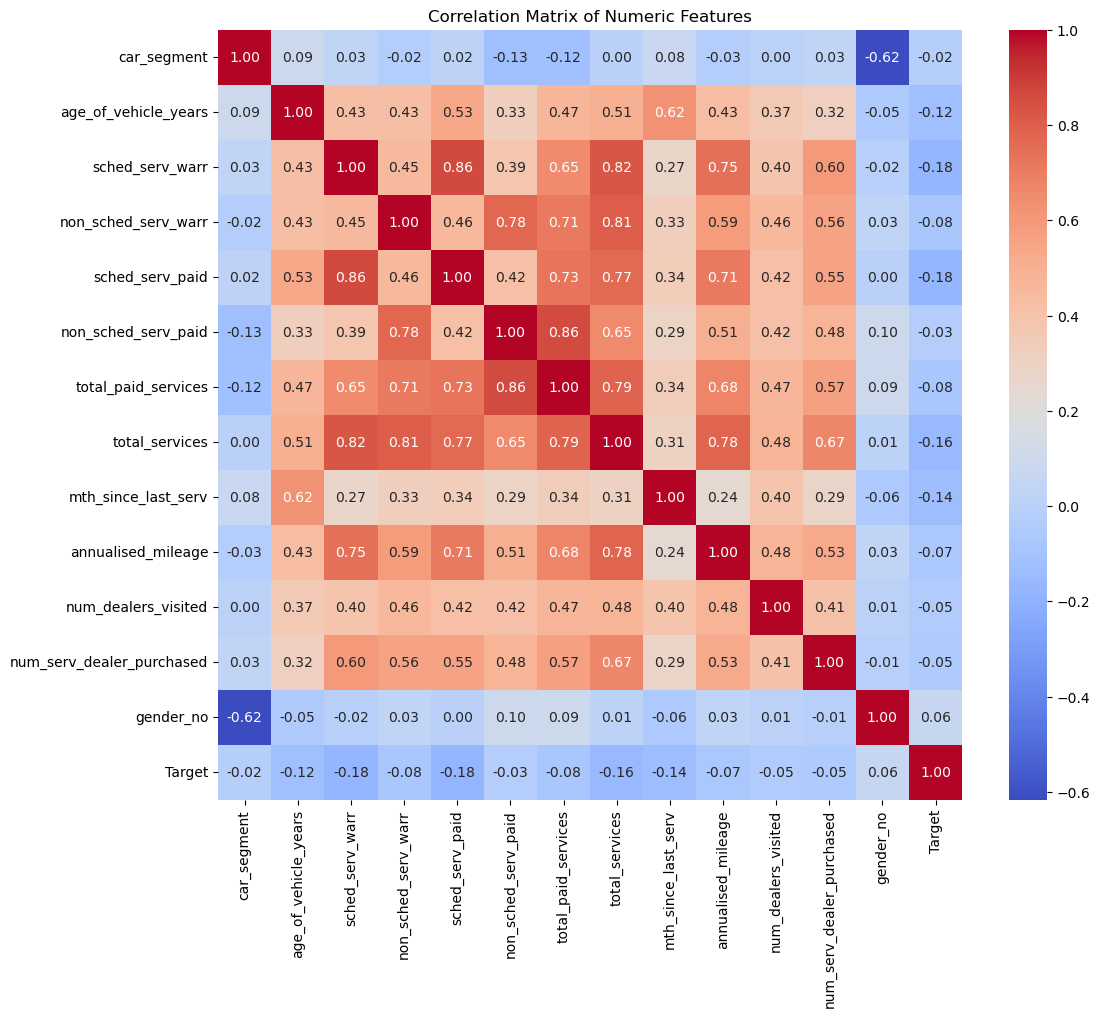

In [25]:
correlation = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

### 4.3 ANOVA - F Test

In [26]:
X_ANOVA = df.drop(['Target'], axis=1)
y_ANOVA = df['Target']

In [27]:
X_train_ANOVA, X_test_ANOVA, y_train_ANOVA, y_test_ANOVA = train_test_split(X_ANOVA,
                                                                            y_ANOVA, 
                                                                            test_size=0.3, random_state=42)

In [28]:
selector = SelectKBest(score_func=f_classif, k=6)
X_selected = selector.fit_transform(X_train_ANOVA, y_train_ANOVA)
selected_indices = selector.get_support(indices=True)
selected_features = X_train_ANOVA.columns[selected_indices]
print("Selected Features:", selected_features)

Selected Features: Index(['age_of_vehicle_years', 'sched_serv_warr', 'sched_serv_paid',
       'total_paid_services', 'total_services', 'mth_since_last_serv'],
      dtype='object')


Using the correlation analysis and the ANOVA-F test, the features with the highest influence on the target columns are idenitified and the above portrayed columns will be the columns that will used for modeling.

The two categorical columns worked on will also be taken into consideration during modeling and their results in the correlation analysis will be ignored due to them being on a different scale as compared to the rest of the dataset in deciles.

### 5. Prepare Data

In [29]:
df = df[['gender_no', 'car_segment', 'age_of_vehicle_years', 'sched_serv_warr', 'sched_serv_paid',
       'total_paid_services', 'total_services', 'mth_since_last_serv', 'Target']]

In [30]:
df.head()

,gender_no,car_segment,age_of_vehicle_years,sched_serv_warr,sched_serv_paid,total_paid_services,total_services,mth_since_last_serv,Target
0,1.0,0,9,2,3,5,6,9,0
1,0.0,2,6,10,10,9,10,6,0
2,1.0,1,9,10,10,10,10,7,0
3,1.0,1,5,8,8,5,6,4,0
4,0.0,2,8,9,10,9,8,5,0


The data is now ready to go ahead with modeling.

### 6. Split Dataset

In [33]:
X = df.drop(['Target'], axis=1)
y = df['Target']

In [34]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [35]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (91895, 8) (91895,)
Validation set shape: (19692, 8) (19692,)
Testing set shape: (19692, 8) (19692,)


As we can see, the data has now been divided into Training, Validation, and Testing sets. The training set consists of 91,895 values while the validation and test sets consist of 19,692 values each.

### 7. Baseline Model
Logistic Regression has been chosen as the baseline model for this experiment. 

In [38]:
baseline_model = LogisticRegression()
baseline_model.fit(X_train, y_train)

LogisticRegression()

In [39]:
y_train_base_pred = baseline_model.predict(X_train)
y_val_base_pred = baseline_model.predict(X_val)
y_test_base_pred = baseline_model.predict(X_test)

# Classification report for training set
print("Training Classification Report:")
print(classification_report(y_train, y_train_base_pred))

# Classification report for validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_base_pred))

# Classification report for test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_base_pred))

Training Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     89427
           1       0.75      0.02      0.04      2468

    accuracy                           0.97     91895
   macro avg       0.86      0.51      0.51     91895
weighted avg       0.97      0.97      0.96     91895

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     19181
           1       0.58      0.01      0.03       511

    accuracy                           0.97     19692
   macro avg       0.78      0.51      0.51     19692
weighted avg       0.96      0.97      0.96     19692

Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     19151
           1       0.78      0.01      0.03       541

    accuracy                           0.97     19692
   macro avg       0.88      0.51 

As we can see, the accuracy remains high for all three tests. The precision, recall, and F1-score is high for the majority class but performs poorly on the minorty class in the baseline model.

### 8. Train Machine Learning Model

In [46]:
model = SVC()

In [47]:
param_grid = {
    'C': [0.1, 1, 10],  
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'linear']
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   9.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   9.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  25.4s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   9.1s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   9.4s


/Users/ronikj/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   9.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   9.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  23.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  24.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   9.3s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 1.1min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  10.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  26.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  26.4s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  10.7s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 1.2min
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=  10.6s
[CV] END ...................

In [50]:
best_svc = SVC(C=10, gamma=0.1, kernel='rbf')

best_svc.fit(X_train, y_train)

y_pred_train = best_svc.predict(X_train)
y_pred_val = best_svc.predict(X_val)

# Print classification report
# print("Classification Report:")
# print(classification_report(y_val, y_pred))

In [51]:
y_pred_test = best_svc.predict(X_test)

### 9. Assess Model Performance

In [52]:
print("Classification Report:")
print(classification_report(y_train, y_pred_train))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     89427
           1       0.91      0.58      0.71      2468

    accuracy                           0.99     91895
   macro avg       0.95      0.79      0.85     91895
weighted avg       0.99      0.99      0.99     91895



In [53]:
print("Classification Report:")
print(classification_report(y_val, y_pred_val))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19181
           1       0.87      0.56      0.68       511

    accuracy                           0.99     19692
   macro avg       0.93      0.78      0.84     19692
weighted avg       0.99      0.99      0.98     19692



In [54]:
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19151
           1       0.88      0.57      0.69       541

    accuracy                           0.99     19692
   macro avg       0.93      0.78      0.84     19692
weighted avg       0.98      0.99      0.98     19692



As seen in the above highlighted performance metrics, the overall preicision, recall, and f1-score stayed high for the majority class but relatively lower for the minority class. This could be due to the class imbalance which is a step that can be taken for future experiments.

### 9. References:

1. Selva Prabhakaran - Youtube - How to impute missing data in categorical features (using MICE) - https://www.youtube.com/watch?v=dm7YNsN_Nwo&ab_channel=SelvaPrabhakaran%28ML%2B%29